In [1]:
import cirq
import numpy as np
import pickle
import json
import os
from collections import Counter
from sklearn.metrics import mean_squared_error

#define utility functions

def simulate(circuit: cirq.Circuit) -> dict:
    """This funcion simulate a cirq circuit (without measurement) and output results in the format of histogram.
    """
    simulator = cirq.Simulator()
    result = simulator.simulate(circuit)
    
    state_vector=result.final_state_vector
    
    histogram = dict()
    for i in range(len(state_vector)):
        population = abs(state_vector[i]) ** 2
        if population > 1e-9:
            histogram[i] = population
    
    return histogram


def histogram_to_category(histogram):
    """This function take a histogram representations of circuit execution results, and process into labels as described in 
    the problem description."""
    assert abs(sum(histogram.values())-1)<1e-8
    positive=0
    for key in histogram.keys():
        digits = bin(int(key))[2:].zfill(20)
        if digits[-1]=='0':
            positive+=histogram[key]
        
    return positive

def count_gates(circuit: cirq.Circuit):
    """Returns the number of 1-qubit gates, number of 2-qubit gates, number of 3-qubit gates...."""
    counter=Counter([len(op.qubits) for op in circuit.all_operations()])
    
    #feel free to comment out the following two lines. But make sure you don't have k-qubit gates in your circuit
    #for k>2
    for i in range(2,20):
        assert counter[i]==0
        
    return counter

def image_mse(image1,image2):
    # Using sklearns mean squared error:
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
    return mean_squared_error(image1, image2)

In [2]:
#load the mock data (for testing only)
files=os.listdir("mock_data")
dataset=list()
for file in files:
    with open('mock_data/'+file, "r") as infile:
        loaded = json.load(infile)
        dataset.append(loaded)

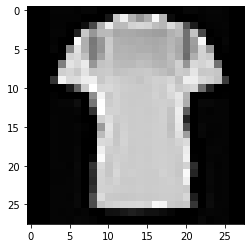

In [3]:
#load the actual hackthon data (fashion-mnist)
images=np.load('data/images.npy')
labels=np.load('data/labels.npy')
#you can visualize it
import matplotlib.pyplot as plt
plt.imshow(images[1], cmap=plt.get_cmap('gray'))

In [4]:
#num_image=len(images)
#new_image=[]
#for i in range(num_image):
#    new_image.append(images[i].resize(16,16))


In [50]:
import scipy
from qiskit.execute_function import execute

num_image=len(images)
noramliz_const=np.max(num_image)
for i in range(num_image):
    images[i]=images[i]/noramliz_const
    
input_data=images
Output_data=labels

In [51]:
outputdata=[]
for i in range(num_image):
    if labels[i] == True:
        outputdata.append(1)
    else:
        outputdata.append(0)

In [52]:
def Image_2_state(image):
    """
    Input: image (array)
    
    return: the coefficients of the inintial state
    """
    L,W=np.shape(image)
    num_q=int(np.ceil(np.log(L*W)/np.log(2)))
    cf=np.zeros((2**num_q),dtype=float)
    flattern_im=image.flatten()
    for i in range(L*W):
        cf[i]=flattern_im[i]
    norm_const=scipy.linalg.norm(cf)
    if norm_const==0:
        cf[0]=1
        return cf
    cf=cf/norm_const
    return cf
        

In [53]:
import qiskit
from qiskit import  transpile
from qiskit import BasicAer
import torch
from torch.autograd import Function
#from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from pennylane.optimize import NesterovMomentumOptimizer
from pennylane import numpy as np
from pennylane import math


backend = BasicAer.get_backend('statevector_simulator')
def encode_qiskit(image):
    """
    The encoder's circuit using QPIE
    image: input image (array)
    return qiskit circuit, number of qubuts
    """
    if isinstance(image, list):
        image=np.array(image)
    L,W=np.shape(image)
    num_q=int(np.ceil(np.log(L*W)/np.log(2)))
    state_vector=Image_2_state(image)
    q = qiskit.QuantumRegister(num_q)
    circuit = qiskit.QuantumCircuit(q)
    #if image[0][0]==0:
    q_indx=[i for i in range(num_q)]
    #print(q_indx)
    #print(state_vector)
    state_vector=state_vector.numpy()
    circuit.initialize(state_vector,q_indx)#rx(np.pi,0)
    circuit=transpile(circuit, backend=backend, optimization_level=3)
    return circuit, num_q

In [61]:
def var_ansatz(weights,num_q,num_rep):
    """
    rx, rz var ansatz
    variational classifier
    weights: the parameter of each rotation gate (Pennylane arraybox)
    num_q: number of qubits
    num_rep: the number of layers
    
    return qiskit variational circuit
    """
    num_w=len(weights)
    qr = qiskit.QuantumRegister(num_q)
    qc=qiskit.QuantumCircuit(qr)
    weights=math.unwrap(weights)
    #print(np.shape(weights))
    for i in range(num_rep):
        #q_i=0
        for j in range(num_q):
            qc.rx(weights[i*2*num_q+2*j],j)
            qc.rz(weights[i*2*num_q+2*j+1],j)
            #q_i+=1
        for j in range(num_q-1):
            qc.cx(j,j+1)
    for j in range(num_q):
        qc.rx(weights[num_q*2*num_rep+2*j],j)
        qc.rz(weights[num_q*2*num_rep+2*j+1],j)
    
    return qc
            
        

def circuit_output(weights, images, num_rep=2, num_shot=1024):
    """
    num_rep : number of layers
    num_shot: number of shots
    weights: the parameter of each rotation gate (Pennylane arraybox)
    image: input image (array)
    """
    circuit, num_q=encode_qiskit(images)
    qr = qiskit.QuantumRegister(num_q)
    cr= qiskit.ClassicalRegister(1)
    qc=qiskit.QuantumCircuit(qr,cr)

    var_cir=var_ansatz(weights,num_q,num_rep)
    qc.append(circuit.to_instruction(),qr[:])
    qc.append(var_cir,qr[:])
    
    qc.measure(qr[num_q//2],cr)
    
    backend = BasicAer.get_backend('statevector_simulator')
    job = execute(qc, backend, shots=num_shot)
    
    Dict_count=job.result().get_counts()
    
    if '0' not in Dict_count:
        return 1
    
    if '1' not in Dict_count:
        return 0

    return (Dict_count['1']-Dict_count['0'])/num_shot

def variational_classifier(weights, images):
    return circuit_output(weights, images)

def cost(weights, Y, predictions):
    #predictions = [variational_classifier(weights, x) for x in X]
    return square_loss(Y, predictions)

def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

In [64]:
opt = NesterovMomentumOptimizer(0.5)
batch_size = 5
num_layers=2
_,num_qubits=encode_qiskit(images[0])

weights_init = 0.01 * np.random.randn((num_layers+1)*num_qubits*2, requires_grad=True)
weights = weights_init
for it in range(5):

    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, len(images), (batch_size,))
    X_batch = images[batch_index]
    Y_batch = labels[batch_index]
    weights, _, _ = opt.step(cost, weights, X_batch, Y_batch)

    # Compute accuracy
    print('Calculating batch accuracy')
    predictions = [np.sign(variational_classifier(weights, x)) for x in X_batch]
    acc = accuracy(Y_batch, predictions)
    print('Calculating batch cost')
    print(
        "Iter: {:5d} | Cost: {:0.7f} | Accuracy: {:0.7f} ".format(
            it + 1, cost(weights, X_batch, Y_batch), acc
        )
    )

Calculating batch accuracy
Calculating batch cost
Iter:     1 | Cost: 0.4000000 | Accuracy: 0.8000000 
Calculating batch accuracy
Calculating batch cost
Iter:     2 | Cost: 0.2000000 | Accuracy: 0.4000000 
Calculating batch accuracy
Calculating batch cost
Iter:     3 | Cost: 0.2000000 | Accuracy: 0.6000000 
Calculating batch accuracy
Calculating batch cost
Iter:     4 | Cost: 0.2000000 | Accuracy: 0.4000000 
Calculating batch accuracy
Calculating batch cost
Iter:     5 | Cost: 0.6000000 | Accuracy: 0.8000000 
